# Optimal transport via Sinkhorn's algorithm,  with Riemannian and Rander costs


# !! Work in progress, unfinished notebook !!

*Summary of this series of notebooks:*
[Adaptive grid discretizations, summary](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/Summary.ipynb)

## Problem description

**Schroedinger's entropic relaxation of the optimal transport problem.** 
This notebook is devoted to solving the optimization problem
$$
    \min_\pi \int_{X \times Y} \left( c(x,y) + \epsilon\ln \frac{\pi(x,y)}{\mu(x) \nu(y)} -\epsilon\right) \,\pi(x,y) \,dx \,dy
$$
where the unknown density $\pi$, on the product space $X \times Y$, is a coupling between two given measures $\mu$ and $\nu$, on $X$ and $Y$ respectively. It is thus subject to the constraints
$$
    \int_X \pi(x,y) dx = \nu(y), \quad \int_Y \pi(x,y) dy = \mu(x),
$$
for all $x \in X$ and $y \in Y$.
Note that the positiviy of $\pi$ is ensured by the presence of the logarithmic term in the optimized functional, and that the marginal constraints ensure that its total mass is one.

**Kantorowich's duality.**
Convex duality yields a maximization problem equivalent to the above one
$$
    \max_{\alpha,\beta} \int_X \alpha(x) \mu(x) dx + \int_Y \beta(y) \nu(y) dy - \epsilon \int_{X\times Y} \mu(x) \nu(y) \exp\left(\frac{\alpha(x)+\beta(y)-c(x,y)} \epsilon\right) dx dy,
$$
where $\alpha$ and $\beta$ are the Kantorowitch potentials, on $X$ and $Y$ respectively.

**Sinkhorn's algorithm.**
Kantorowichs reformulation is an unconstrained concave maximization, w.r.t. two variables $\alpha$ and $\beta$.
If one of these two potentials is fixed, say $\beta$, then the corresponding optimal $\alpha$ admits the explicit expression
$$
    \alpha(x) = -\epsilon \ln \left(\int_Y \mu(x) \nu(y) \exp(\frac{\beta(y) - c(x,y)} \epsilon) dy\right).
$$
Alternate maximization, w.r.t. $\alpha$ and $\beta$ successively, is referred to as Sinkhorn's algorithm in this context.

***References.***
The implementation presented in this notebook was, in the case of Riemannian metrics (the discussion of Rander metrics is new), first introduced in:  
* Solomon, J., de Goes, F., Peyré, G., Cuturi, M., Butscher, A., Nguyen, A., et al. (2015). Convolutional wasserstein distances: Efficient optimal transportation on geometric domains. ACM Transactions on Graphics (TOG), 34(4), 66.

One of the first numerical implementations of Sinkhorn's algorithm for solving an optimal transport problem is:
* Kosowsky, J. J., & Yuille, A. L. (1994). The invisible hand algorithm: Solving the assignment problem with statistical physics. Neural Networks, 7(3), 477–490.

<!--- Also Gallichon 2009 ? --->

## Distance and distance-squared cost functions

**Linear and quadratic cost.** Assume that $X=Y$ is a metric space. It is common to consider a cost function, in the optimal transport problem, growing as a power of the distance: 
$$
    c(x,y) = \frac 1 p d(x,y)^p,
$$
for some exponent $p$. In this notebook, we focus on two classical choices:
* $p=1$, the linear cost, is often adequate for *loss functions*, that is measuring the distance between weighted sets. Indeed, the low exponent limits the sensitivity to outliers. The optimal transport cost with $p=1$ is often referred to as the *earth mover distance*. It is an excellent substitute, with typically improved result but a larger computational cost, to Kernel distances or the Haussdorff distance.
* $p=2$, the quadratic cost, is often adequate for *mapping problems*, that is defining a pairwise matching between sets. Indeed, theoretical often results guarantee, under adequate assumptions, that optimal transport problem with this cost uniquely defines such a mapping.

As a side note, large exponents $p>2$ are excessively sensitive to outliers, exponents $p \in ]0,1[$ raise computational issues due to the concavity of the cost along geodesics, and exponents $p<0$ yield repulsive costs with some applications in quantum mechanics.

**Updating Kantorowitch's potential using Varadhan's formula.**
The main step in Sinkhorn's algorithm is the computation of a convolution
$$
    A(x) = \int_Y K(x,y) B(y) dy 
$$
where the kernel is 
$$
    K(x,y) = \exp(-\frac {d(x,y)^p}{p \epsilon}).
$$
In the asymptotic regime $\epsilon \to 0$ of vanishing entropy regularization, we can rely on Varadhan's formulas to expresse this kernel as the fundamental solution to a differential operator, see notebook [I Computing distance maps and geodesics using Varadhan's formulas](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/VaradhanGeodesics.ipynb). 
More precisely:
* $p=1$ and a Riemannian or Rander (asymmetric) distance. We use the approximation $A \approx u$ where
$$
    u +2 \epsilon <\omega, \nabla u> - \epsilon^2 {\rm div} (D \nabla u) = B,
$$
and where the diffusion tensor $D$ and vector field $\omega$ depend on the problem geometry. ($D=M^{-1}$ and $\omega=0$ for a Riemannian metric.)
* $p=2$ and a Riemannian distance. We use the approximation $A \approx u(\epsilon, \cdot)$, where $u(0,\cdot) = B$ and 
$$
    \partial_t u = {\rm div} (D \nabla u).
$$

**Choice of relaxation parameter $\epsilon$.**
Schrodinger's relaxation of optimal transport induces a blurring of the measures over a radius $\sqrt \epsilon$ typically. In order to limit this effect, one would like to choose $\epsilon$ as small as possible. In the implementation presented in this notebook, the main limitation to do so comes from the stability and accuracy of the finite difference schemes used in Varadhan's formulas, which typically require that $\epsilon$ is a few times larger than the gridscale $h$. 

## 0. Importing the required libraries

In [1]:
import sys; sys.path.append("..") # Allow import from parent directory
from NumericalSchemes import LinearParallel as lp
from NumericalSchemes import LinearPDE

In [2]:
import numpy as np
import scipy.linalg; import scipy.sparse; import scipy.sparse.linalg 
from matplotlib import pyplot as plt

A few utility functions.

In [3]:
def streamplot_ij(X,Y,VX,VY,*varargs,**kwargs):
    return plt.streamplot(X.T,Y.T,VX.T,VY.T,*varargs,**kwargs) # Transpose everything

In [36]:
def RangeIndex(rg,x):
    """Find the index of a value x in an equispaced range rg"""
    return int(round( (x-rg[0])/(rg[-1]-rg[0]) * (len(rg)-1)))

def MakeRHS(seeds,axes):
    rhs=np.full(tuple(len(ax) for ax in axes),0.)
    for seed in seeds:
        rhs[tuple(RangeIndex(ax,x) for ax,x in zip(axes,seed))] = 1
    return rhs

## 1. Euclidean distance as cost

As a starter, we solve an optimal transport problem with a cost function that is symmetric, isotropic, and translation invariant: the Euclidean distance, or the squared Euclidean distance. 

Note: Numerous alternative numerical methods exist in this (very) specific case, and the one presented in this notebook is not particularly optimal. 

In [35]:
#Define the domain [0,1]^2, sampled on a cartesian grid
gridScale = 0.005
axis0 = np.arange(0,1,gridScale); axes = (axis0,axis0)
coords = np.array(np.meshgrid(*axes,indexing='ij'))
bounds=coords[0].shape

# Generate the diffusion tensors (inverse to the metric tensors)
metric = lp.identity(bounds)

In [5]:
def Gaussian(center,sigma,coords):
    dim = len(center)
    return (2*np.pi*sigma**2)**(-dim/2.)*np.exp(-sum( (X-x)**2 for X,x in zip(coords,center) )/(2*sigma**2))

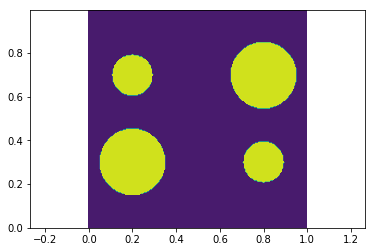

In [6]:
#muX=Gaussian((0.2,0.3),0.1,coords)+Gaussian((0.1,0.8),0.1,coords); muY=Gaussian((0.8,0.5),0.2,coords); 
muX=2*Gaussian((0.2,0.3),0.1,coords)+Gaussian((0.2,0.7),0.1,coords);muY = Gaussian((0.8,0.3),0.1,coords)+2*Gaussian((0.8,0.7),0.1,coords);

muX=(muX>np.max(muX)/3).astype(float); muY=(muY>np.max(muY)/3).astype(float);
muX/=muX.sum(); muY/=muY.sum()

plt.axis('equal')
plt.contourf(*coords,muX+muY);

In [7]:
distance_to_center = np.sqrt(sum((x-0.5)**2 for x in coords))

### 1.1 Linear cost $c(x,y) = \|x-y\|$ (Earth mover distance)

Our first step is to define the domain, and implement the convolution operator appearing in Sinkhorn's algorithm.

In [58]:
def RiemannConvolution1(metric,gridScale,epsilon=None):
    """Returns a convolution operator with the kernel K(x,y) = exp(-d(x,y)/eps)
     Approximation based on Varadhan's formula."""
    # Define PDE operators in Varadhan's formula
    bounds = metric.shape[2:]
    mult = np.full(bounds,1.)
    diff = lp.inverse(metric)
    if epsilon is None:
        epsilon = gridScale #np.sqrt(np.max(lp.trace(diff))) * 2 * gridScale
    
    # Generate the sparse matrix
    triplets = LinearPDE.OperatorMatrix(epsilon**2 * diff,
    mult=mult,gridScale=gridScale,boundaryConditions='Neumann')
    pde = scipy.sparse.coo_matrix(triplets).tocsc()
    
    # Setup the solver
    solver = scipy.sparse.linalg.factorized(pde)
    convolution = lambda x : solver(x.flatten()).reshape(bounds) 
    
    return (convolution,convolution), epsilon

In [59]:
convolutions, epsilon = RiemannConvolution1(metric,gridScale)

In [60]:
params = (muX,muY),convolutions,epsilon

Let us check that convolution works as expected.

Reconstructed distance error (within radius 0.3) : 0.0007127672889002817


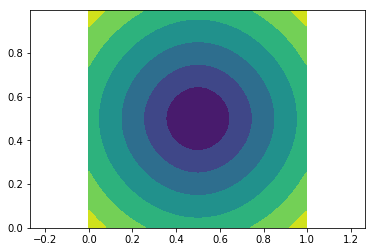

In [61]:
rhs = distance_to_center<0.05
distance = -epsilon*np.log(convolutions[0](rhs))
distance -= np.min(distance)

print("Reconstructed distance error (within radius 0.3) :",
      np.max( (distance_to_center-distance-0.05)[distance_to_center<0.3]))

plt.axis('equal')
plt.contourf(*coords,distance);

In [62]:
def KantorowichGain(potentials_exp, densities, convolutions,epsilon):
    """Returns the gain, and the Kantorowich potentials"""
    muX,muY = densities
    eX,eY = potentials_exp
    convX,convY = convolutions
    
    pX,pY = (epsilon*np.log(e) for e in potentials_exp) # Kantorowich potentials
    gain = np.sum(muX*pX) + np.sum(muY*pY) - epsilon*np.sum(muX*eX*convY(muY*eY))
    return gain,(pX,pY)

Next we implement the update to the Kantorowich potentials appearing in Sinkhorn's alternate minimization algorithm

In [63]:
def SinkhornUpdate(potentials_exp, densities, convolutions, simultaneous=False, normalize=True):
    """A single update of the Kantorowich potentials in Sinkhorn's algorithm"""
    muX,muY = densities
    eX0,eY0 = potentials_exp
    convX,convY = convolutions
    
    eX = 1./convY(muY*eY0)      
    eX_ = eX0 if simultaneous else eX
    eY = 1./convX(muX*eX_)
    
    if normalize:
        mult = np.exp(np.sum(muX*np.log(eX)))
        eX/=mult
        eY*=mult
    
    return eX,eY

We are all set to solve the optimal transport problem.

In [64]:
eX, eY = np.full(bounds,1.),np.full(bounds,1.)
for i in range(10):
#    print(KantorowichGain((eX,eY), *params)[0])
    eX, eY = SinkhornUpdate((eX,eY), *params[:-1])

In [65]:
def TransportFlow(potential,metric,gridScale):
    grad = np.array(np.gradient(potential,gridScale))
    return lp.solve_AV(metric,grad)

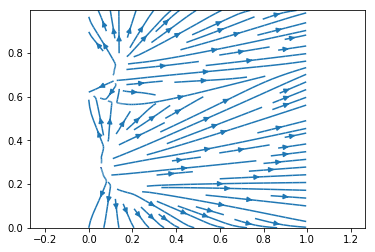

In [66]:
_,(pX,pY) = KantorowichGain((eX,eY), *params)
plt.axis('equal')
streamplot_ij(*coords,*TransportFlow(pY,metric,gridScale));

In [67]:
def TransportPlan(potentials_exp, densities, convolutions, coords, reverse=False):
    eX,eY = potentials_exp; muX,muY = densities; convX,convY = convolutions
    if reverse: eX,eY,muX,muY,convX,convY = eY,eX,muY,muX,convY,convX
    
    def expectY(a): return eX*convY(muY*eY*a)
    m0 = expectY(1.) # Should be identically 1, up to discretization error
    m1 = np.array([expectY(x) for x in coords])
    m1/=m0; 


#    m2 = np.array([[expectY(x*y) for x in coords] for y in coords])
#    m2/=m0; m2 -= lp.outer_self(m1)
    return m1,m2

In [68]:
m1,m2 = TransportPlan((eX,eY), *params[:-1], coords, reverse=False)
pos = muX>(np.max(muX)/3)

**TODO** Ca ne va pas trop, il faut avouer...

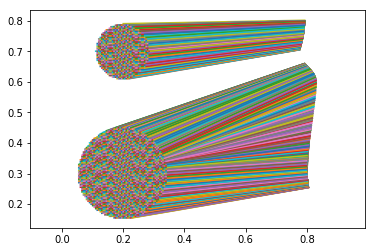

In [69]:
plt.axis('equal')
seed = coords[:,pos]
tip = m1[:,pos]
plt.plot((seed[0],tip[0]),(seed[1],tip[1]));

In [70]:
def TransportImage(rho,potentials_exp,densities,convolutions,reverse=False):
    eX,eY = potentials_exp; muX,muY = densities; convX,convY = convolutions
    if reverse: eX,eY,muX,muY,convX,convY = eY,eX,muY,muX,convY,convX
    return convX(rho*eX)*eY*muY

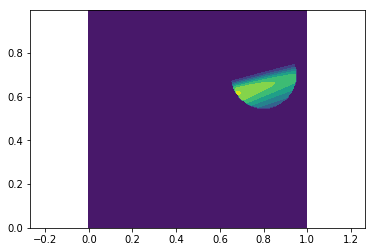

In [72]:
#rho=muX
#rho = muX*(coords[1]<0.5)
rho = MakeRHS([(0.2,0.4)],axes)
imRho = TransportImage(rho,(eX,eY),*params[:-1])
plt.axis('equal')
plt.contourf(*coords,imRho);

### 1.2 Quadratic cost

In [69]:
def RiemannConvolution2(metric,gridScale,epsilon=None,steps=None):
    """Convolution with the kernel exp( -d(x,y)**2 /(2*epsilon) ).
    Approximation based on Varadhan's formula"""
    
    # We actually use an implicit scheme to solve a diffusion equation
    if steps is None: steps = 5
        
    # Relation : 
    (convX,convY),epsilon = RiemannConvolution1(metric,gridScale,epsilon=epsilon)
    
    def iterate(f,x,n): return x if n==0 else iterate(f,f(x),n-1)    
    convX2 = lambda x : iterate(convX,x,steps)
    convY2 = lambda x : iterate(convY,x,steps)
    
    return (convX2,convY2),steps * epsilon**2

In [70]:
convolutions, epsilon = RiemannConvolution2(metric,gridScale)

In [71]:
params = (muX,muY),convolutions,epsilon

Let us check that the convolution operator is correct.

Reconstructed distance error (within radius 0.3) : 0.05104590727019556


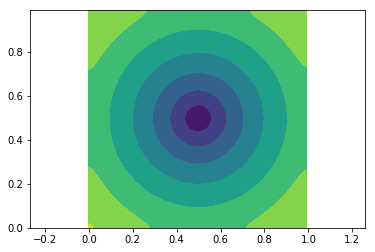

In [72]:
rhs = distance_to_center < 0.05
distance = -2*epsilon*np.log(convolutions[0](rhs))
distance -= np.min(distance)
distance = np.sqrt(distance)

print("Reconstructed distance error (within radius 0.3) :",
      np.max( (distance_to_center-0.05-distance)[distance_to_center<=0.3] ) )

plt.axis('equal')
plt.contourf(*coords,distance);

In [76]:
eX, eY = np.full(bounds,1.),np.full(bounds,1.)
for i in range(10):
    print(KantorowichGain((eX,eY), *params)[0])
    eX, eY = SinkhornUpdate((eX,eY), *params[:-1])

-2.1440133969624164e-09
0.07826120807465085
0.07920047017925058
0.07945659376509397
0.07956049877301033
0.07960019412929611
0.07961478495947738
0.0796200218003854
0.07962187444455229
0.0796225242211554


In [77]:
m1,_ = TransportPlan((eX,eY), *params[:-1], coords)
pos = muX>(np.max(muX)/5)

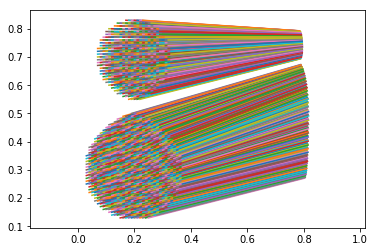

In [78]:
plt.axis('equal')
seed = coords[:,pos]
tip = m1[:,pos]
plt.plot((seed[0],tip[0]),(seed[1],tip[1]));

In [91]:
bounds

(50, 50)

In [94]:
np.sqrt(epsilon)

0.1264911064067352